In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
df = pd.read_csv('DATA\\Train_Data.csv')
df

,age,sex,bmi,smoker,region,children,charges
0,21.000000,male,25.745000,no,northeast,2,3279.868550
1,36.976978,female,25.744165,yes,southeast,3,21454.494239
2,18.000000,male,30.030000,no,southeast,1,1720.353700
3,37.000000,male,30.676891,no,northeast,3,6801.437542
4,58.000000,male,32.010000,no,southeast,1,11946.625900
...,...,...,...,...,...,...,...
3625,48.820767,female,41.426984,no,northwest,4,10987.324964
3626,38.661977,female,26.202557,no,southeast,2,11735.844352
3627,56.000000,male,40.300000,no,southwest,0,10602.385000
3628,48.061207,female,34.930624,no,southeast,1,8976.140452


# We're trying to predict 'charges' based off the other features

In [4]:
df.isna().sum()

age         0
sex         0
bmi         0
smoker      0
region      0
children    0
charges     0
dtype: int64

# Pre-processing

In [5]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
def preprocess_inputs(df):
    
    df = df.copy()
    #Wrapper for gender
    sex_wrapper = {'male':0, 'female':1}
    df.sex = df.sex.replace(sex_wrapper)

    #Wrapper for smoker
    df.smoker.value_counts()
    smoker_wrapper = {'no':0, 'yes':1}
    df.smoker = df.smoker.replace(smoker_wrapper)

#Dealing with region - OHE
#     ohe = OneHotEncoder()
#     feat_array = ohe.fit_transform(df[['region']]).toarray()
#     df_ohe = pd.DataFrame(feat_array, columns=ohe.categories_)
#     df = pd.concat([df, df_ohe], axis = 1)
#     df = df.drop('region', axis=1)
    df = pd.get_dummies(df, columns=['region'])
    
    return df

In [7]:
df = preprocess_inputs(df)

In [8]:
df.isna().sum()

age                 0
sex                 0
bmi                 0
smoker              0
children            0
charges             0
region_northeast    0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64

# Splitting and training model

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [10]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [11]:
y = df.charges
X = df.drop('charges', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=1)

scaler = StandardScaler()

s_X_train = scaler.fit_transform(X_train)
s_X_test = scaler.transform(X_test)

#Linear Regression

LR = LinearRegression()
LR.fit(s_X_train, y_train)
y_pred = LR.predict(s_X_test)

In [12]:
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2

In [13]:
#XGBoost Regressor
xgbr = XGBRegressor(verbosity=0)
xgbr.fit(X_train, y_train)

y_pred_XGBR = xgbr.predict(X_test)

In [14]:
def get_metrics(preds, actual, model_type):
    r2s = r2(preds, actual)
    maes = mae(preds, actual)
    mses = mse(preds, actual)
    rmses = math.sqrt(mses)
#     return rmse, mse, mae, r2
    df = pd.DataFrame([r2s, maes, mses, rmses, model_type]).transpose()
    df.columns = ['r2 coeff.', 'MAE', 'MSE', 'RMSE', 'Type of model']
    return df

In [15]:
df_metrics = get_metrics(y_pred, y_test, 'Linear Regression')
df_metrics_X = get_metrics(y_pred_XGBR, y_test, 'XGBR')

df_metrics = pd.concat([df_metrics, df_metrics_X], axis=0)
df_metrics

,r2 coeff.,MAE,MSE,RMSE,Type of model
0,0.624266,3917.399973,34823672.123227,5901.158541,Linear Regression
0,0.87101,1733.224338,14806208.474594,3847.883636,XGBR


# Let's perform some feature engineering and outlier analysis to try and fix up our model
1. Outlier Analysis and EDA will be performed to better understand the dataset and determine if there are any outliers.

2. We'll work to implement different regression models (i.e. Lasso, Ridge, OLS) and see how they perform.

3. We'll evaluate and compare the results to the original Linear Regression Model

# 1. Outlier Analysis & EDA

A. Creating box plots to visualize and see if there are any outliers

In [16]:
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns

In [19]:
df = pd.read_csv('DATA\\Train_Data.csv')
df

,age,sex,bmi,smoker,region,children,charges
0,21.000000,male,25.745000,no,northeast,2,3279.868550
1,36.976978,female,25.744165,yes,southeast,3,21454.494239
2,18.000000,male,30.030000,no,southeast,1,1720.353700
3,37.000000,male,30.676891,no,northeast,3,6801.437542
4,58.000000,male,32.010000,no,southeast,1,11946.625900
...,...,...,...,...,...,...,...
3625,48.820767,female,41.426984,no,northwest,4,10987.324964
3626,38.661977,female,26.202557,no,southeast,2,11735.844352
3627,56.000000,male,40.300000,no,southwest,0,10602.385000
3628,48.061207,female,34.930624,no,southeast,1,8976.140452


In [20]:
df.isna().sum()

age         0
sex         0
bmi         0
smoker      0
region      0
children    0
charges     0
dtype: int64

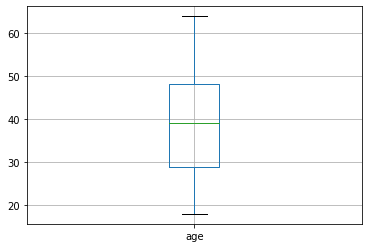

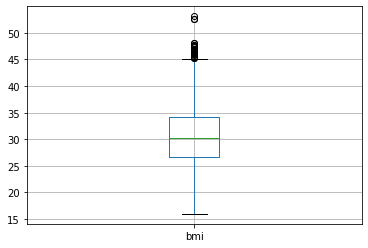

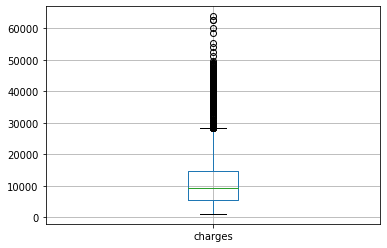

In [21]:
numerical_columns = ['age', 'bmi', 'charges']
for column in numerical_columns:
    df.boxplot(column)
    plt.show()

BMI might be a bit concerning, only the two or so that might be above 50. We can look a bit further into this to see just how much of an outlier these values are using z-score analysis

In [22]:
def gen_zscores(df, col):
    df['Z-score_'+col] = zscore(df[col])

[gen_zscores(df, nc) for nc in numerical_columns]

[None, None, None]

In [23]:
df.describe()

,age,bmi,children,charges,Z-score_age,Z-score_bmi,Z-score_charges
count,3630.000000,3630.000000,3630.000000,3630.000000,3.630000e+03,3.630000e+03,3.630000e+03
mean,38.887036,30.629652,2.503581,12784.808644,-4.306320e-16,-4.418871e-16,-9.787090e-19
std,12.151029,5.441307,1.712568,10746.166743,1.000138e+00,1.000138e+00,1.000138e+00
min,18.000000,15.960000,0.000000,1121.873900,-1.719189e+00,-2.696351e+00,-1.085461e+00
25%,29.000000,26.694526,1.000000,5654.818262,-8.137910e-01,-7.232946e-01,-6.635829e-01
50%,39.170922,30.200000,3.000000,9443.807222,2.336630e-02,-7.897214e-02,-3.109445e-01
75%,48.343281,34.100000,4.000000,14680.407505,7.783330e-01,6.378662e-01,1.764220e-01
max,64.000000,53.130000,5.000000,63770.428010,2.067020e+00,4.135669e+00,4.745194e+00


In [24]:
df = df[df['Z-score_bmi'] < 4] # Less than 4 because we want all the BMI's where it's less than 4 SD away

In [25]:
#Examining 'charges'
df[df['Z-score_charges'] > 3]

,age,sex,bmi,smoker,region,children,charges,Z-score_age,Z-score_bmi,Z-score_charges
24,63.000000,female,32.200000,yes,southwest,2,47305.305000,1.984711,0.288637,3.212797
35,51.000000,male,42.900000,yes,southeast,2,47462.894000,0.997005,2.255347,3.227464
56,60.000000,male,39.900000,yes,southwest,0,48173.361000,1.737785,1.703933,3.293586
155,61.000000,male,35.860000,yes,southeast,0,46599.108400,1.820094,0.961362,3.147072
164,44.661095,female,42.700382,yes,southeast,2,45826.924321,0.475256,2.218657,3.075205
...,...,...,...,...,...,...,...,...,...,...
3369,55.763926,female,38.760630,yes,southeast,2,47412.030298,1.389118,1.494512,3.222730
3412,61.000000,male,36.300000,yes,southwest,1,47403.880000,1.820094,1.042236,3.221971
3443,59.310381,male,31.892829,yes,northeast,3,46182.830749,1.681023,0.232178,3.108329
3496,51.983128,female,41.818559,yes,southeast,2,47273.110908,1.077925,2.056573,3.209801


'charges' column is alright, no extreme outliers

In [26]:
df = df.drop(['Z-score_age', 'Z-score_bmi', 'Z-score_charges'], axis=1)
df

,age,sex,bmi,smoker,region,children,charges
0,21.000000,male,25.745000,no,northeast,2,3279.868550
1,36.976978,female,25.744165,yes,southeast,3,21454.494239
2,18.000000,male,30.030000,no,southeast,1,1720.353700
3,37.000000,male,30.676891,no,northeast,3,6801.437542
4,58.000000,male,32.010000,no,southeast,1,11946.625900
...,...,...,...,...,...,...,...
3625,48.820767,female,41.426984,no,northwest,4,10987.324964
3626,38.661977,female,26.202557,no,southeast,2,11735.844352
3627,56.000000,male,40.300000,no,southwest,0,10602.385000
3628,48.061207,female,34.930624,no,southeast,1,8976.140452


In [27]:
df.isna().sum()

age         0
sex         0
bmi         0
smoker      0
region      0
children    0
charges     0
dtype: int64

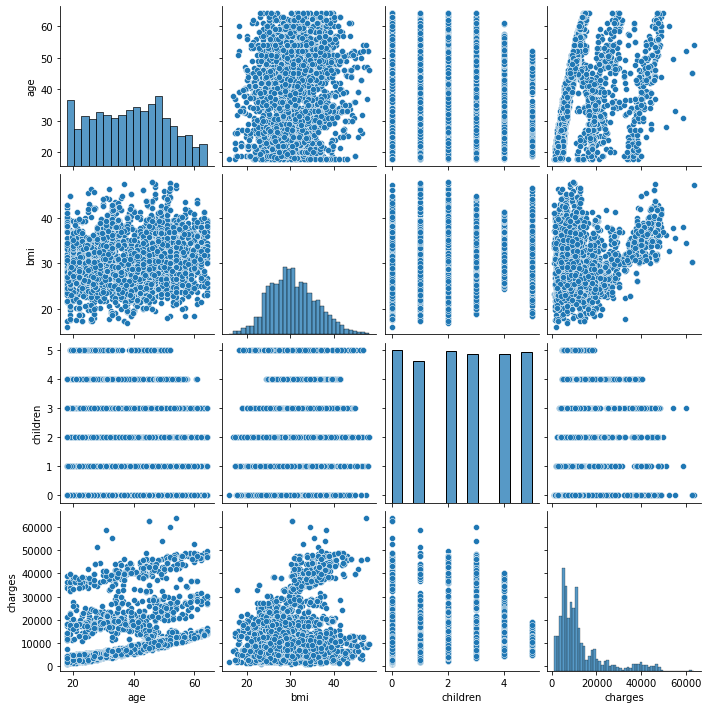

In [28]:
sns.pairplot(df);


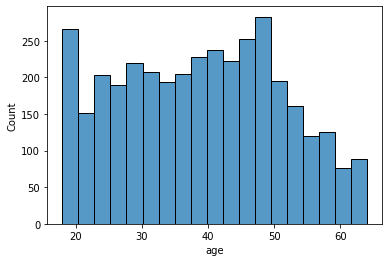

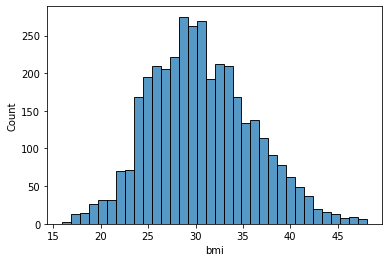

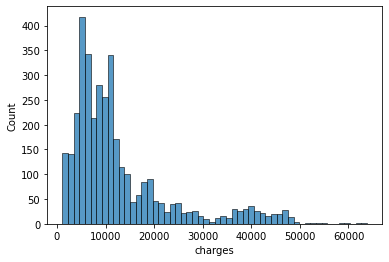

[None, None, None]

In [29]:
# sns.histplot(x='charges', data=df);
def gen_histplots(column, df):
    sns.histplot(x=column, data=df);
    plt.show();
    
[gen_histplots(column, df) for column in numerical_columns]

In [30]:
categorical_columns = df.select_dtypes(include='object').columns
categorical_columns

Index(['sex', 'smoker', 'region'], dtype='object')

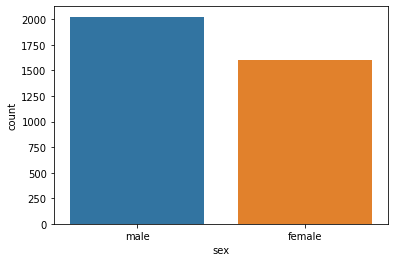

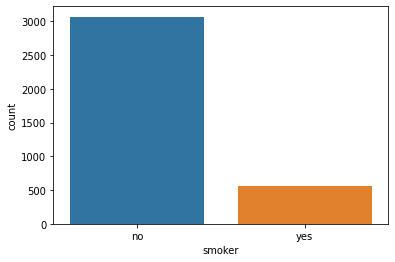

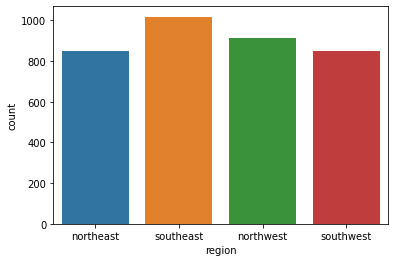

[None, None, None]

In [31]:
def gen_countplots(column, df=df):
    sns.countplot(x=column, data=df);
    plt.show();

[gen_countplots(column) for column in categorical_columns]

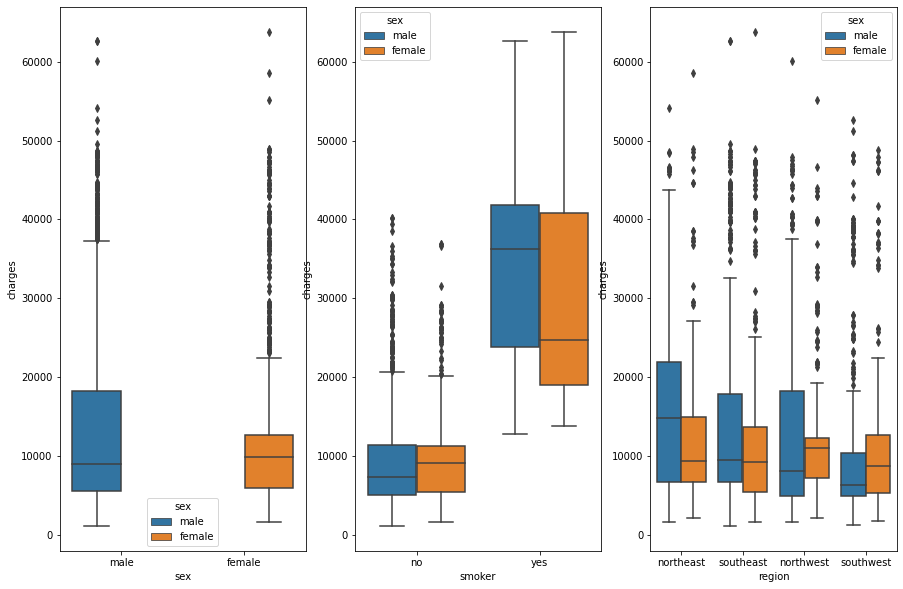

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
for var, subplot in zip(categorical_columns, ax.flatten()):
    sns.boxplot(x=var, y='charges', hue = 'sex', data=df, ax=subplot)

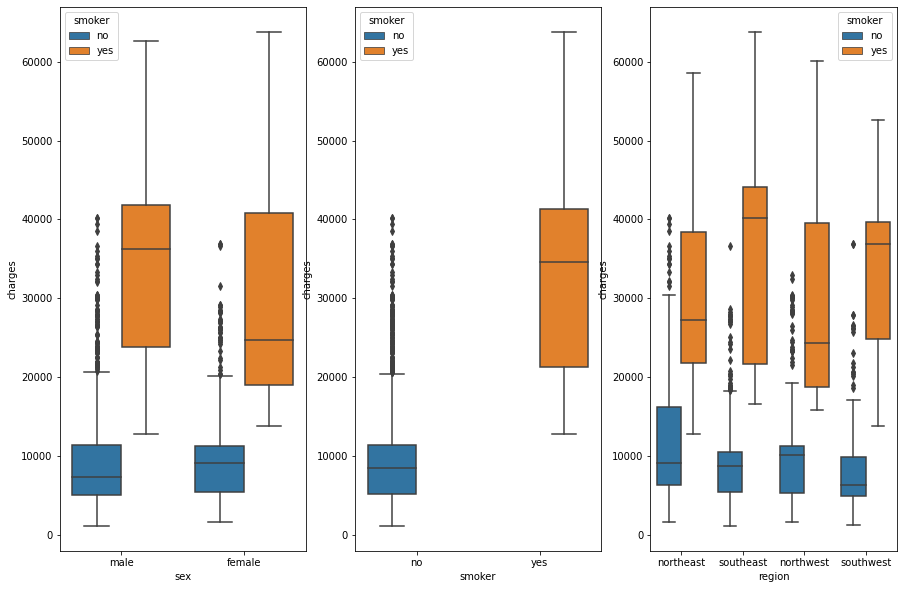

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
for var, subplot in zip(categorical_columns, ax.flatten()):
    sns.boxplot(x=var, y='charges', hue = 'smoker', data=df, ax=subplot)

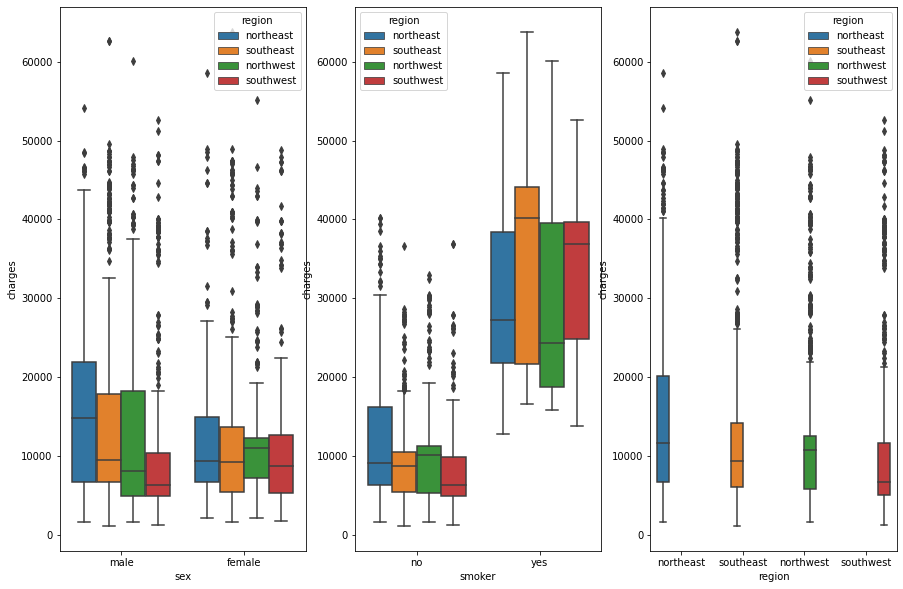

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
for var, subplot in zip(categorical_columns, ax.flatten()):
    sns.boxplot(x=var, y='charges', hue = 'region', data=df, ax=subplot)

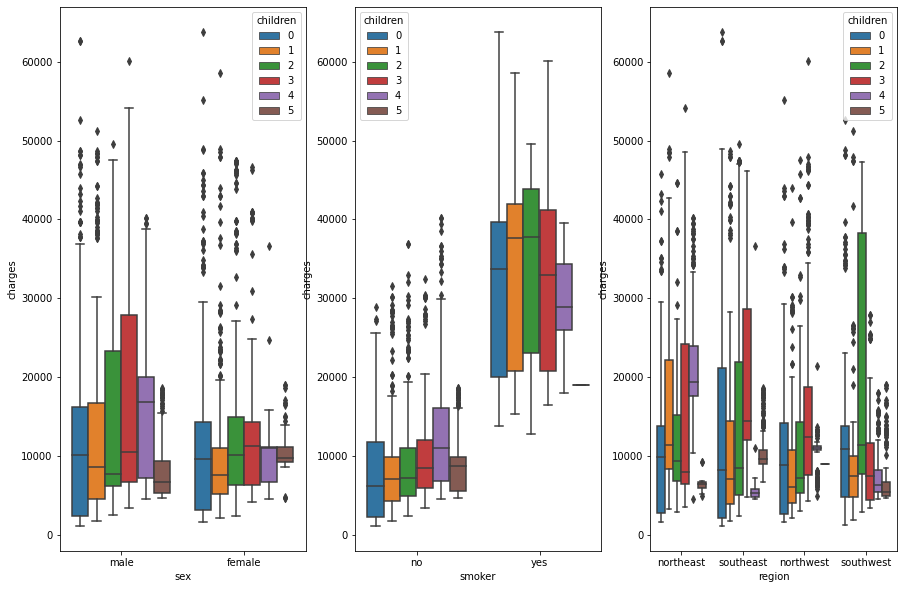

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
for var, subplot in zip(categorical_columns, ax.flatten()):
    sns.boxplot(x=var, y='charges', hue = 'children', data=df, ax=subplot)

Insights:

1. If you're a smoker you will usually be incurring higher charges.

2. Northeast region also (sometimes) tends to incur higher charges

3. Men also tend to incur higher charges

# 2. Implementing different regression models

Pre-processing

In [36]:
df = preprocess_inputs(df)
df

,age,sex,bmi,smoker,children,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,21.000000,0,25.745000,0,2,3279.868550,1,0,0,0
1,36.976978,1,25.744165,1,3,21454.494239,0,0,1,0
2,18.000000,0,30.030000,0,1,1720.353700,0,0,1,0
3,37.000000,0,30.676891,0,3,6801.437542,1,0,0,0
4,58.000000,0,32.010000,0,1,11946.625900,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
3625,48.820767,1,41.426984,0,4,10987.324964,0,1,0,0
3626,38.661977,1,26.202557,0,2,11735.844352,0,0,1,0
3627,56.000000,0,40.300000,0,0,10602.385000,0,0,0,1
3628,48.061207,1,34.930624,0,1,8976.140452,0,0,1,0


In [37]:
df.isna().sum()

age                 0
sex                 0
bmi                 0
smoker              0
children            0
charges             0
region_northeast    0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64

In [38]:
y = df.charges
X = df.drop('charges', axis=1)

In [39]:
from sklearn.linear_model import Lasso, Ridge,LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [40]:
scaler = StandardScaler()

In [41]:
def test(models, data, iterations):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        rmse_train = []
        rmse_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, 
                                                                test_size= 0.2)
            
            s_X_train = scaler.fit_transform(X_train)
            s_X_test = scaler.transform(X_test)
            
            #R2 score
            r2_train.append(r2(y_train, models[i].fit(s_X_train, y_train).predict(s_X_train)))
            r2_test.append(r2(y_test, models[i].fit(s_X_train, y_train).predict(s_X_test)))
            
            #RMSE
            rmse_train.append(mse(y_train, models[i].fit(s_X_train, y_train).predict(s_X_train), squared=False))
            rmse_test.append(mse(y_test, models[i].fit(s_X_train, y_train).predict(s_X_test), squared=False))
            
        results[i] = [np.mean(r2_train), np.mean(r2_test), np.mean(rmse_train), np.mean(rmse_train)]
        
    return pd.DataFrame(results, index=['Train_r2', 'Test_r2', 'Train_RMSE', 'Test_RMSE'])

pd.options.display.float_format = '{:.5f}'.format

In [42]:
models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge()}

In [43]:
test(models, df, iterations = 10)

,OLS,Lasso,Ridge
Train_r2,0.71922,0.71640,0.71762
Test_r2,0.71171,0.72413,0.72033
Train_RMSE,5682.49732,5709.59071,5693.02350
Test_RMSE,5682.49732,5709.59071,5693.02350


In [44]:
test(models, df, iterations = 30)

,OLS,Lasso,Ridge
Train_r2,0.71836,0.71779,0.71784
Test_r2,0.71672,0.71930,0.71880
Train_RMSE,5690.58611,5683.33557,5685.46652
Test_RMSE,5690.58611,5683.33557,5685.46652


In [45]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS': LinearRegression(),
           'Lasso': GridSearchCV(Lasso(), param_grid=lasso_params).fit(X, y).best_estimator_,
           'Ridge': GridSearchCV(Ridge(), param_grid=ridge_params).fit(X, y).best_estimator_,}

In [46]:
test(models2, df, iterations = 30)

,OLS,Lasso,Ridge
Train_r2,0.71909,0.71815,0.71814
Test_r2,0.71359,0.71739,0.70338
Train_RMSE,5689.44999,5691.64666,5697.34840
Test_RMSE,5689.44999,5691.64666,5697.34840


Using LassoCV and RidgeCV to find optimal hyperparameters

In [47]:
from numpy import arange

In [48]:
m = {'LassoCV': LassoCV(alphas=arange(0.01,1,0.01), cv=5, normalize=True).fit(X,y),
     'RidgeCV': RidgeCV(alphas=[0.001,0.01,1,10], cv=5, normalize=True).fit(X,y),
     'OLS': LinearRegression()}

c:\Users\pushp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
c:\Users\pushp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a

# 3. Evaluation and comparison to original Linear Regression model and XGBRegessor model

Original:

In [49]:
df_metrics

,r2 coeff.,MAE,MSE,RMSE,Type of model
0,0.62427,3917.39997,34823672.12323,5901.15854,Linear Regression
0,0.87101,1733.22434,14806208.47459,3847.88364,XGBR


Revised:

In [50]:
test(m, df, iterations=30)

c:\Users\pushp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
c:\Users\pushp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a

,LassoCV,RidgeCV,OLS
Train_r2,0.72148,0.71796,0.71698
Test_r2,0.70388,0.71841,0.72172
Train_RMSE,5671.81113,5695.45191,5693.98071
Test_RMSE,5671.81113,5695.45191,5693.98071


The initial fit was with an r2 coefficient of .624 and a RMSE of ~5900. The new revised fit deems that the best (non-treebased model) has been improved a decent amount due to the outlier analysis and hyperparameter optimizations

In [51]:
#Re-testing XGBR
xgbr = XGBRegressor(verbosity=0)
xgbr.fit(X_train, y_train)

y_pred_XGBR = xgbr.predict(X_test)


print(f'the r2 score for XGBR is: {r2(y_test,y_pred_XGBR)}, and the RMSE is: {mse(y_test,y_pred_XGBR, squared=False)}')
# print(f'The r2 score for XGBR_train is: {r2(y_train, y_pred_XGBR)} and for XGBR_test its: {r2(y_test, y_pred_XGBR)}')
      
# print(f'The rmse score for XGBR_train is: {mse(y_train, y_pred_XGBR, Squared=False)} and for XGBR_test its: {mse(y_test, y_pred_XGBR, Squared=False)}')

the r2 score for XGBR is: 0.8750422248091001, and the RMSE is: 3847.8836357917085


Comparing the new XGBR r2 and RMSE scores from the previous model we can see improvements here as well.